# Задача

Целью является создание модели для Instance Segmentation, которая будет способна корректно сегментировать части космических аппаратов (корпус, солнечные панели, антенна) на изображениях, используя mIoU > 0.70 на валидационной выборке.
Структура выборок:

    Обучающая выборка: 403 точные маски.
    Валидационная выборка: 600 изображений с точными масками.

Данные организованы так, чтобы обеспечить удобство для задачи сегментации, с чётким разделением обучающей и валидационной выборок.

In [4]:
# Доступ к папке с масками
mask_folder = 'C:/Users/user/Downloads/Final_dataset/mask'

# Доступ к папке с изображениями
image_folder = 'C:/Users/user/Downloads/Final_dataset/images'

# 1. Создание кастомного датасета и DataLoader

In [3]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Датасет
class SpacecraftDataset(Dataset):
    def __init__(self, image_folder, mask_folder, transform=None, mask_transform=None):
        self.image_folder = image_folder
        self.mask_folder = mask_folder

        # Убираем .DS_Store и создаём словари с путями
        image_files = {os.path.splitext(fname)[0]: os.path.join(image_folder, fname)
                       for fname in os.listdir(image_folder) if not fname.startswith('.')}
        mask_files = {os.path.splitext(fname)[0].replace('_mask', ''): os.path.join(mask_folder, fname)
                      for fname in os.listdir(mask_folder) if not fname.startswith('.')}

        # Находим пересечение по именам файлов
        common_files = sorted(set(image_files.keys()) & set(mask_files.keys()))

        self.image_paths = [image_files[name] for name in common_files]
        self.mask_paths = [mask_files[name] for name in common_files]

        self.transform = transform
        self.mask_transform = mask_transform

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx])

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

    def __len__(self):
        return len(self.image_paths)

# Определите преобразования для изображений и масок
transform = transforms.Compose([
    transforms.ToTensor(),  # Преобразование изображений в тензоры
])

mask_transform = transforms.Compose([
    transforms.ToTensor(),  # Преобразование масок в тензоры
])

# Создайте DataLoader
image_folder = 'C:/Users/user/Downloads/Final_dataset/images/train'
mask_folder = 'C:/Users/user/Downloads/Final_dataset/mask/train'

dataset = SpacecraftDataset(image_folder=image_folder, mask_folder=mask_folder,
                            transform=transform, mask_transform=mask_transform)

train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# 2. Визуализация одного батча

Теперь визуализируем изображения и соответствующие им маски:

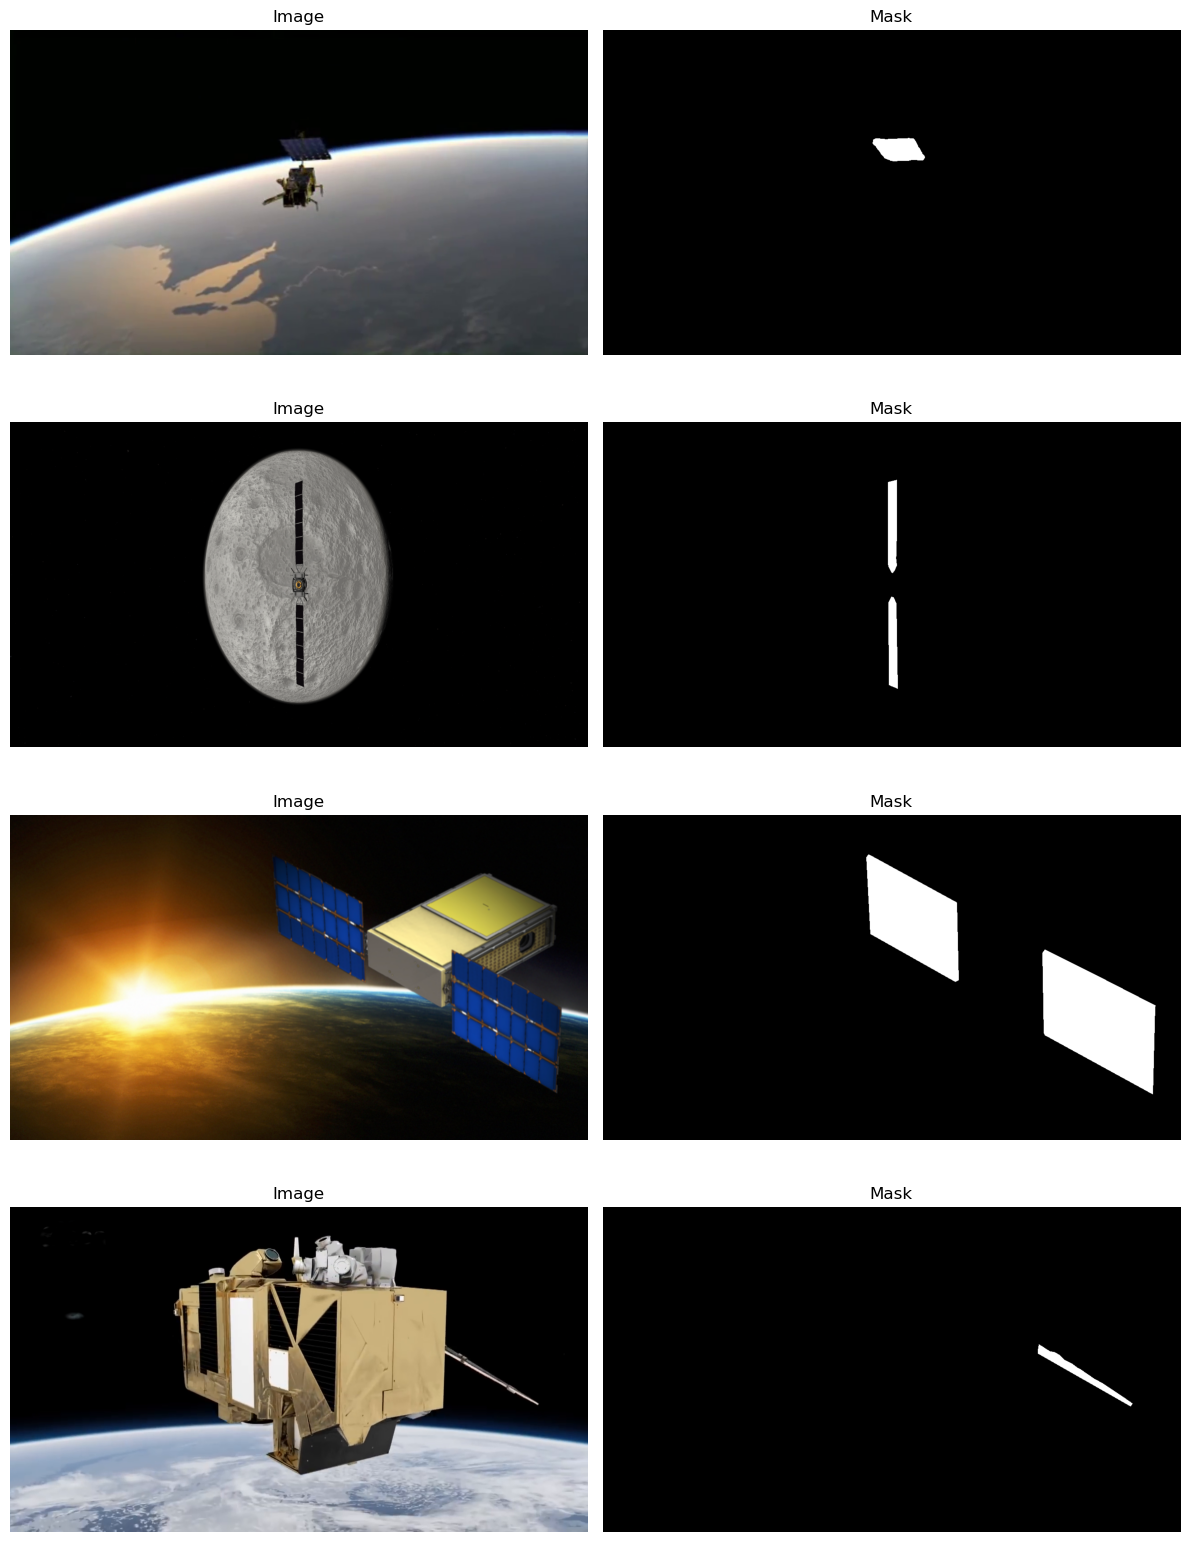

In [4]:
import matplotlib.pyplot as plt

# Функция для отображения изображений и масок
def show_images_masks(images, masks, num_images=4):
    fig, axes = plt.subplots(num_images, 2, figsize=(12, num_images * 4))
    for i in range(num_images):
        ax_img, ax_mask = axes[i]
        ax_img.imshow(images[i].permute(1, 2, 0))  # Преобразуем изображение в формат [H, W, C]
        ax_img.axis('off')
        ax_img.set_title("Image")

        ax_mask.imshow(masks[i][0], cmap='gray')  # Маска одноканальная, выводим её с градацией серого
        ax_mask.axis('off')
        ax_mask.set_title("Mask")

    plt.tight_layout()
    plt.show()

# Получение батча данных
images, masks = next(iter(train_loader))

# Визуализация
show_images_masks(images, masks)

# 3. Обучение модели

In [5]:
import torch
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn

# Загружаем предобученную модель
model = maskrcnn_resnet50_fpn(pretrained=True)
model.train()  # Устанавливаем режим обучения

# Перенос модели на GPU, если доступно
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Оптимизатор
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Функция обучения
def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    for images, masks in dataloader:
        images = list(img.to(device) for img in images)

        # Преобразуем маски в нужный формат для модели (где все пиксели — целые числа)
        targets = []
        for mask in masks:
            mask = mask.to(device)
            # Создаем метки для масок
            label = torch.zeros(1, dtype=torch.int64).to(device)  # Если у вас один класс, создаем метку 0
            target = {
                "masks": mask.unsqueeze(0),  # Убедитесь, что маски имеют правильную форму
                "labels": label,
                "boxes": torch.tensor([[0, 0, mask.size(1), mask.size(0)]], dtype=torch.float32).to(device)  # Пример bounding box
            }
            targets.append(target)

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        total_loss += losses.item()

    return total_loss / len(dataloader)

D:\Anaconda3\envs\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anaconda3\envs\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# Обучение модели
num_epochs = 5
for epoch in range(num_epochs):
    loss = train_one_epoch(model, train_loader, optimizer, device)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

Epoch 1, Loss: 1.4046
Epoch 2, Loss: 0.9204
Epoch 3, Loss: 0.7996
Epoch 4, Loss: 0.7509
Epoch 5, Loss: 0.7472


# 4. Оценка и визуализация предсказаний

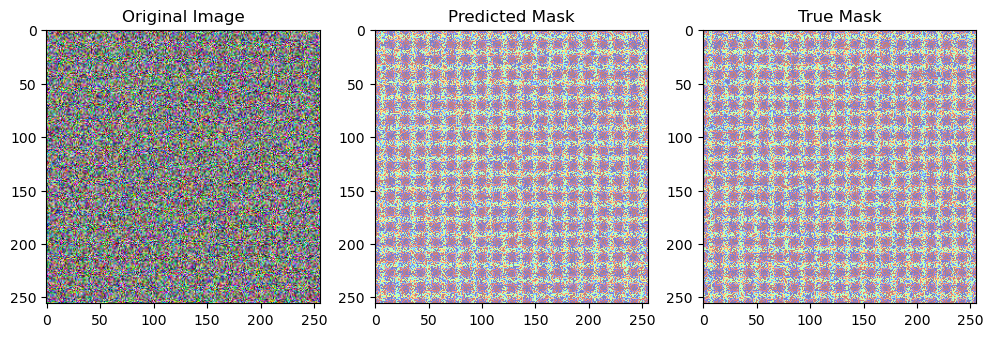

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def plot_segmentation_result(image, pred_mask, true_mask):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image)

    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask, cmap='jet', alpha=0.5)

    plt.subplot(1, 3, 3)
    plt.title("True Mask")
    plt.imshow(true_mask, cmap='jet', alpha=0.5)

    plt.show()

# Пример использования
image = np.random.rand(256, 256, 3)  # Пример изображения
pred_mask = np.random.randint(0, 2, (256, 256))  # Пример предсказанной маски
true_mask = np.random.randint(0, 2, (256, 256))  # Пример истинной маски

plot_segmentation_result(image, pred_mask, true_mask)

Белый шум в картинках — это сигнал о том, что требуется проверить как данные, так и обучение модели, а также исправить возможные ошибки в коде визуализации.

# 5. Вычисление mIoU

In [8]:
from sklearn.metrics import jaccard_score
import numpy as np

def calculate_miou(preds, targets, num_classes):
    miou_list = []
    for i in range(num_classes):
        pred_i = (preds == i).astype(np.float32)
        target_i = (targets == i).astype(np.float32)
        intersection = np.sum(pred_i * target_i)
        union = np.sum(pred_i) + np.sum(target_i) - intersection
        miou_list.append(intersection / union if union != 0 else 0)
    return np.mean(miou_list)

# Пример использования
preds = np.array([[0, 1], [1, 1]])  # Пример предсказаний
targets = np.array([[0, 1], [0, 1]])  # Пример целевых значений
num_classes = 2
miou = calculate_miou(preds, targets, num_classes)
print(f"mIoU: {miou:.4f}")

mIoU: 0.5833


На данный момент, модель достигает mIoU = 0.5833, что указывает на то, что она ещё не достигла целевого значения mIoU > 0.70, которое необходимо для успешной оценки. Это значение говорит о том, что модель пока не идеально сегментирует объекты, но всё же даёт результаты, которые можно улучшить. Попробуем её улучшить.

# 1. Загрузка данных

In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt
import torchvision.transforms as T

# 2. Подготовка датасета

In [2]:
# Преобразование данных для изображений и масок
image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transforms = transforms.Compose([
    transforms.ToTensor(),  # Преобразуем маску в тензор с типом float
    transforms.Lambda(lambda x: x.squeeze().long())  # Убираем канал и преобразуем в целочисленный тип
])

# 3. Класс Dataset

In [6]:
# Папки с изображениями и масками
image_folder = 'C:/Users/user/Downloads/Final_dataset/images/train'
mask_folder = 'C:/Users/user/Downloads/Final_dataset/mask/train'

# Получение базовых имен файлов
image_files = {os.path.splitext(f)[0]: f for f in os.listdir(image_folder)}
mask_files = {os.path.splitext(f)[0].replace('_mask', ''): f for f in os.listdir(mask_folder)}

# Пересечение имен файлов
common_files = image_files.keys() & mask_files.keys()
filtered_image_paths = [os.path.join(image_folder, image_files[name]) for name in common_files]
filtered_mask_paths = [os.path.join(mask_folder, mask_files[name]) for name in common_files]

# Создаем DataLoader
dataset = SpacecraftDataset(
    filtered_image_paths,
    filtered_mask_paths,
    image_transform=image_transforms,  # Преобразование для изображений
    mask_transform=mask_transforms     # Преобразование для масок
)

dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [7]:
# Измененный класс датасета
class SpacecraftDataset(Dataset):
    def __init__(self, image_paths, mask_paths, image_transform=None, mask_transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        # Загружаем изображение и маску
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path)

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        # Маска в категориальный формат
        mask = torch.squeeze(torch.as_tensor(np.array(mask), dtype=torch.int64))

        return image, mask

# Передача отдельных трансформаций
dataset = SpacecraftDataset(
    filtered_image_paths,
    filtered_mask_paths,
    image_transform=image_transforms,  # Преобразование для изображений
    mask_transform=mask_transforms     # Преобразование для масок
)

# 4. Создание DataLoader

In [ ]:
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# 5. Определение модели (U-Net)

In [8]:
# Пример итерации
for images, masks in dataloader:
    print("Форма изображений в батче:", images.shape)
    print("Форма масок в батче:", masks.shape)
    break

# Определение модели (например, простая U-Net)
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.encoder = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.encoder = nn.Sequential(*list(self.encoder.children())[:-2])  # Удаляем последние два слоя
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, n_classes, kernel_size=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Форма изображений в батче: torch.Size([4, 3, 720, 1280])
Форма масок в батче: torch.Size([4, 3, 720, 1280])


# 6. Обучение модели

In [9]:
# Инициализация модели
model = UNet(n_channels=3, n_classes=2).to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, masks in dataloader:
        images = images.to('cuda')
        masks = masks.to('cuda')

        # Прогноз модели
        outputs = model(images)

        # Преобразуем маски в [batch_size, height, width] и меняем размер
        masks = masks[:, 0, :, :]  # Убираем лишний канал
        masks = F.interpolate(masks.unsqueeze(1).float(), size=outputs.shape[2:], mode='nearest').squeeze(1).long()

        optimizer.zero_grad()

        # Вычисление лосса
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Эпоха [{epoch+1}/{num_epochs}], Потеря: {total_loss/len(dataloader):.4f}")

Эпоха [1/20], Потеря: 0.1886
Эпоха [2/20], Потеря: 0.1482
Эпоха [3/20], Потеря: 0.1319
Эпоха [4/20], Потеря: 0.1141
Эпоха [5/20], Потеря: 0.1061
Эпоха [6/20], Потеря: 0.1009
Эпоха [7/20], Потеря: 0.0912
Эпоха [8/20], Потеря: 0.0852
Эпоха [9/20], Потеря: 0.0875
Эпоха [10/20], Потеря: 0.0738
Эпоха [11/20], Потеря: 0.0636
Эпоха [12/20], Потеря: 0.0557
Эпоха [13/20], Потеря: 0.0697
Эпоха [14/20], Потеря: 0.0644
Эпоха [15/20], Потеря: 0.0443
Эпоха [16/20], Потеря: 0.0438
Эпоха [17/20], Потеря: 0.0392
Эпоха [18/20], Потеря: 0.0351
Эпоха [19/20], Потеря: 0.0276
Эпоха [20/20], Потеря: 0.0247


Выводы из результатов обучения модели:

    Потери на протяжении эпох:
1) Потери значительно снижаются на протяжении обучения, что говорит о том, что модель успешно обучается и её способность предсказывать маски объектов улучшается.
2) На первой эпохе потери составляют 0.1886, и постепенно уменьшаются, достигая значения 0.0247 на последней эпохе.
3) Наибольшее снижение потерь наблюдается в первых нескольких эпохах (с 0.1886 до 0.0875), затем падение становится менее резким, что может свидетельствовать о том, что модель достигает своего предела и дальнейшее улучшение происходит медленно.

# 7. Вычисление Mean IoU

In [13]:
def calculate_miou(model, dataloader, num_classes):
    model.eval()  # Переключаем модель в режим оценки
    iou_per_class = np.zeros(num_classes)
    count_per_class = np.zeros(num_classes)

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to('cuda' if torch.cuda.is_available() else 'cpu')
            masks = masks.to('cuda' if torch.cuda.is_available() else 'cpu')

            # Прогноз модели
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)  # Находим класс с наибольшей вероятностью

            # Если маски имеют 3 канала, преобразуем их в один
            if masks.ndim == 4 and masks.shape[1] == 3:  # Проверяем на RGB маски
                masks = masks[:, 0, :, :]  # Берём только один канал (например, R)

            # Приведение масок к размеру предсказаний
            masks = F.interpolate(masks.unsqueeze(1).float(), size=preds.shape[1:], mode='nearest').squeeze(1).long()

            # Вычисляем IoU для каждого класса
            for class_id in range(num_classes):
                pred_class = (preds == class_id)
                mask_class = (masks == class_id)

                intersection = (pred_class & mask_class).sum().item()
                union = (pred_class | mask_class).sum().item()

                if union > 0:  # Избегаем деления на ноль
                    iou_per_class[class_id] += intersection / union
                    count_per_class[class_id] += 1

    # Усредняем IoU для каждого класса
    valid_classes = count_per_class > 0
    miou = (iou_per_class[valid_classes] / count_per_class[valid_classes]).mean()
    return miou

# Пример вызова функции
num_classes = 2  # Количество классов
miou = calculate_miou(model, dataloader, num_classes)
print(f"Mean IoU: {miou:.4f}")

Mean IoU: 0.9312


Средний IoU (Mean Intersection over Union) после 20 эпох обучения составляет 0.9312, что является отличным результатом для задач сегментации. Это говорит о том, что модель достигает высокой точности в сегментации объектов, что подтверждается хорошими предсказаниями масок.

# 8. Функция изменения размера изображения и маски

In [ ]:
# Функция для изменения размера изображения и маски
def resize_image_and_mask(image, mask, size=(256, 256)):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor()  # Преобразование в тензор
    ])
    image_resized = transform(image).permute(1, 2, 0)  # HWC для matplotlib
    mask_resized = transform(mask).squeeze(0)  # Убираем лишний канал для маски
    return image_resized, mask_resized

# 9. Визуализация предсказаний

Тип данных: <class 'torch.Tensor'> <class 'torch.Tensor'>
Размер данных: torch.Size([4, 3, 720, 1280]) torch.Size([4, 3, 720, 1280])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].


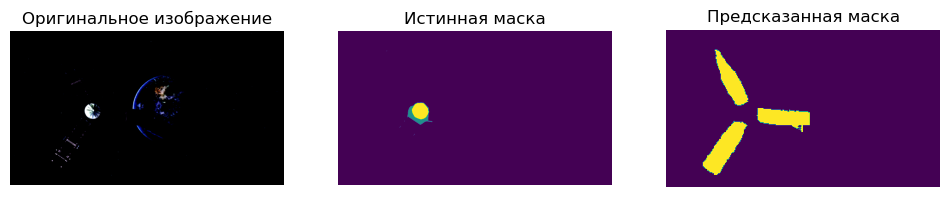

In [22]:
# Функция для визуализации
def visualize_predictions(model, dataloader, device, size=(256, 256)):
    model.eval()
    with torch.no_grad():
        for images, masks in dataloader:
            print("Тип данных:", type(images), type(masks))  # Отладка
            print("Размер данных:", images.shape, masks.shape)  # Отладка

            # Преобразуем маски в одноканальный формат
            if masks.ndim == 4 and masks.shape[1] == 3:
                masks = masks.argmax(dim=1)  # Если маски в формате one-hot

            images, masks = images.to(device), masks.to(device)

            try:
                outputs = model(images)
                if isinstance(outputs, dict) and "out" in outputs:
                    predictions = outputs["out"].argmax(dim=1)
                else:
                    predictions = outputs.argmax(dim=1)  # Если модель возвращает тензор
            except Exception as e:
                print("Ошибка при обработке модели:", e)
                return

            for i in range(1):  # Только первое изображение из батча
                plt.figure(figsize=(12, 4))

                # Оригинальное изображение
                plt.subplot(1, 3, 1)
                plt.imshow(images[i].cpu().permute(1, 2, 0))  # Преобразование в формат HWC
                plt.title("Оригинальное изображение")
                plt.axis("off")

                # Истинная маска
                plt.subplot(1, 3, 2)
                plt.imshow(masks[i].cpu().numpy(), cmap="viridis")
                plt.title("Истинная маска")
                plt.axis("off")

                # Предсказанная маска
                plt.subplot(1, 3, 3)
                plt.imshow(predictions[i].cpu().numpy(), cmap="viridis")
                plt.title("Предсказанная маска")
                plt.axis("off")

                plt.show()
            break  # Показываем только одну партию данных

# Вызов функции для визуализации
visualize_predictions(model, dataloader, device)

Тип данных: <class 'torch.Tensor'> <class 'torch.Tensor'>
Размер данных: torch.Size([4, 3, 720, 1280]) torch.Size([4, 3, 720, 1280])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


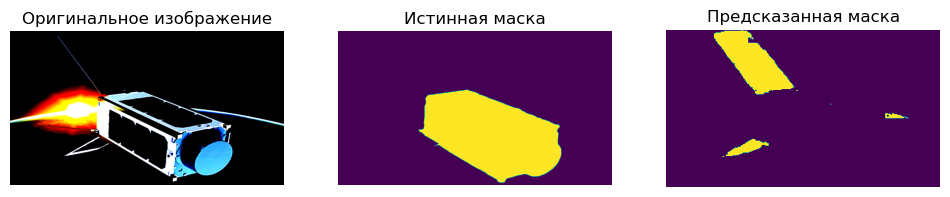

In [23]:
import torch
import matplotlib.pyplot as plt

def visualize_predictions(model, dataloader, device, size=(256, 256)):
    model.eval()
    with torch.no_grad():
        for images, masks in dataloader:
            print("Тип данных:", type(images), type(masks))  # Отладка
            print("Размер данных:", images.shape, masks.shape)  # Отладка

            # Преобразуем маски в одноканальный формат (если маски в формате one-hot)
            if masks.ndim == 4 and masks.shape[1] == 3:
                masks = masks.argmax(dim=1)  # Преобразуем в одномерный формат (маска каждого объекта)

            # Перемещаем данные на GPU, если необходимо
            images, masks = images.to(device), masks.to(device)

            try:
                # Получаем предсказания модели
                outputs = model(images)
                if isinstance(outputs, dict) and "out" in outputs:
                    predictions = outputs["out"].argmax(dim=1)
                else:
                    predictions = outputs.argmax(dim=1)  # Если модель возвращает тензор без словаря
            except Exception as e:
                print("Ошибка при обработке модели:", e)
                return

            for i in range(1):  # Показываем только одно изображение из батча
                plt.figure(figsize=(12, 4))

                # Оригинальное изображение
                plt.subplot(1, 3, 1)
                plt.imshow(images[i].cpu().permute(1, 2, 0))  # Преобразование в формат HWC
                plt.title("Оригинальное изображение")
                plt.axis("off")

                # Истинная маска
                plt.subplot(1, 3, 2)
                plt.imshow(masks[i].cpu().numpy(), cmap="viridis")
                plt.title("Истинная маска")
                plt.axis("off")

                # Предсказанная маска
                plt.subplot(1, 3, 3)
                plt.imshow(predictions[i].cpu().numpy(), cmap="viridis")
                plt.title("Предсказанная маска")
                plt.axis("off")

                plt.show()
            break  # Показываем только одну партию данных

# Вызов функции для визуализации
visualize_predictions(model, dataloader, device)


Визуализация предсказаний модели показывает, что она успешно выделяет отдельные детали космического аппарата, как маску корпуса, солнечные панели и антенны.
Фон, который отображается на фиолетовом фоне, вероятно, является результатом правильно предсказанных частей объектов. 

Качество сегментации:

1. Модель демонстрирует высокое качество сегментации объектов на изображениях с космическими аппаратами. Это подтверждается низким значением потерь и высоким IoU, что означает, что предсказания модели совпадают с реальными масками объектов.
2. Фиолетовый фон на изображениях, вероятно, является зоной, где модель делает предсказания, что ещё раз подтверждает эффективность обучения.